# Приключения Алисы в Стране Чудес (NLP)

В этом проекте я буду разными способами анализировать и визуализировать текст произведения Льюиса Кэрролла. Затем с помощью нейронной сети на PyTorch я попробую решить задачу частеречной разметки.

## Загрузка, установка и импорт

In [0]:
!rm -rf ./*                                                                                       # clean directory
!pip install pymorphy2 > /dev/null                                                                # install morphological analyzer
!git clone -q -b v2.1 https://github.com/buriy/spacy-ru.git > /dev/null                           # download ru2 for spacy
!mv ./spacy-ru/ru2/ .                                                                             # configure ru2
!wget -q https://raw.githubusercontent.com/tesemnikov-av/NLP-rep/master/alice_in_wonderland.txt   # load the text of the tale
!pip install pyconll > /dev/null                                                                  # easily work with CoNLL files 
!wget -q -O ru_syntagrus-ud-train.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train.conllu # text with POS Tags in CoNLL format

In [2]:
# pandas
import pandas as pd
import numpy as np

# visualization assistance 
import matplotlib.pyplot as plt  
import networkx as nx  
plt.figure(figsize=(15, 15))
from wordcloud import WordCloud

# GENSIM
import gensim
from gensim.models import Word2Vec

# pymorphy2
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

# NLTK
import nltk
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt' , quiet=True)
stop_words = stopwords.words('russian')
stop_words.extend(['я','что', 'глава' , 'это', 'так', 'вот', 'быть', 'как', 'в', '—', '–', 'к', 'на', '...'])

# SPACY
import ru2
import spacy
from spacy import displacy
nlp = spacy.load('ru2')

# for deep learning
import torch

# SKLEARN IMPORTS
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# others
import io
import itertools
import multiprocessing
import re
import pyconll

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<Figure size 1080x1080 with 0 Axes>

## Взаимодействие персонажей

In [3]:
with open('alice_in_wonderland.txt') as r:
  raw_text = r.readlines()

persons = [ 'Алиса', 'Кролик', 'Додо', 'Гусеница' , 'Кот', 'Герцогиня', 'Болванщик' ,'Заяц', 'Соня', 'Грифон', 'Черепаха', 'Королева']

def cooccurrence(text, persons):
    """
    Returns a dictionary of match counts for all possible name pairs in the text.
    """
    possible_pairs = list(itertools.combinations(persons, 2))
    cooccurring = dict.fromkeys(possible_pairs, 0)
    for sent in sent_tokenize(str(text)):
          for pair in possible_pairs:
              if pair[0] in sent and pair[1] in sent:
                  cooccurring[pair] += 1
    return cooccurring

pairs = cooccurrence(raw_text,persons)

# How many times have the characters met in a fairy tale
print(pairs)

# delete variable
del raw_text

{('Алиса', 'Кролик'): 16, ('Алиса', 'Додо'): 2, ('Алиса', 'Гусеница'): 15, ('Алиса', 'Кот'): 16, ('Алиса', 'Герцогиня'): 16, ('Алиса', 'Болванщик'): 22, ('Алиса', 'Заяц'): 17, ('Алиса', 'Соня'): 10, ('Алиса', 'Грифон'): 16, ('Алиса', 'Черепаха'): 12, ('Алиса', 'Королева'): 16, ('Кролик', 'Додо'): 0, ('Кролик', 'Гусеница'): 0, ('Кролик', 'Кот'): 0, ('Кролик', 'Герцогиня'): 1, ('Кролик', 'Болванщик'): 1, ('Кролик', 'Заяц'): 1, ('Кролик', 'Соня'): 0, ('Кролик', 'Грифон'): 0, ('Кролик', 'Черепаха'): 0, ('Кролик', 'Королева'): 2, ('Додо', 'Гусеница'): 0, ('Додо', 'Кот'): 0, ('Додо', 'Герцогиня'): 0, ('Додо', 'Болванщик'): 0, ('Додо', 'Заяц'): 0, ('Додо', 'Соня'): 0, ('Додо', 'Грифон'): 0, ('Додо', 'Черепаха'): 0, ('Додо', 'Королева'): 0, ('Гусеница', 'Кот'): 0, ('Гусеница', 'Герцогиня'): 0, ('Гусеница', 'Болванщик'): 0, ('Гусеница', 'Заяц'): 0, ('Гусеница', 'Соня'): 0, ('Гусеница', 'Грифон'): 0, ('Гусеница', 'Черепаха'): 0, ('Гусеница', 'Королева'): 0, ('Кот', 'Герцогиня'): 0, ('Кот', 'Болв

In [0]:
def person_communication(name):
  """
  Visualization of the interaction of characters.
  """
  G=nx.Graph()
  for pair, wgt in pairs.items():
    if wgt>0:
      G.add_edge(pair[0], pair[1], weight = wgt)
  D = nx.ego_graph(G, name)
  edges, weights = zip(*nx.get_edge_attributes(D, "weight").items())
  pos = nx.spring_layout(D)
  nx.draw(D, pos, node_color='b', node_size=10, with_labels=True)
  nx.draw_networkx_nodes(D, pos, nodelist=[name], node_size=100, node_color='r')

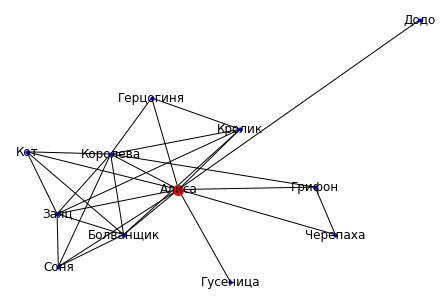

In [5]:
# with whom in the fairy tale Alice met
person_communication('Алиса')

## Дистрибутивная семантика и теория заговора

In [0]:
def get_Cyrillic(text):
    """
    Get the words completely in Cyrillic.
    """
    tokens = re.sub('[^а-яА-Я]+', ' ', text).strip()
    tokens = word_tokenize(tokens)
    tokens = [i for i in tokens if (i not in stop_words)]
    tokens = [ morph.parse(i)[0].normal_form for i in tokens ]
    return ' '.join(tokens)
 
def prepare_text(filename_from, filename_to, lang):
    """
    Prepare text for word2vec.LineSentence.
    """
    try:
      original_text = io.open(filename_from).read()
      with open(filename_to, 'w', encoding='utf-8') as f:
        for sentence in nltk.sent_tokenize(original_text, lang):
            print(get_Cyrillic(sentence.lower()), file=f)
    except BaseException as e:
      print ("Error loading data: ", e)

def train_word2vec(filename, dist_semantics = 'FastText' , size=200, window=5, min_count=3, sg=1):
    """
    filename - corpus file in LineSentence format, 
    dist_semantics - use Word2Vec or FastText,
    window - maximum distance between the current and predicted word within a sentence,
    min_count - ignores all words with total frequency lower than this,
    sg - training algorithm: 1 for skip-gram; otherwise CBOW.
    """
    data = gensim.models.word2vec.LineSentence(filename)
    if dist_semantics == 'FastText':
      return gensim.models.FastText(sentences=data, size=size, window=window, min_count=min_count, workers=multiprocessing.cpu_count(), sg=sg)
    elif dist_semantics == 'Word2Vec':
    #gensim.models.Word2Vec
      return Word2Vec(data, size=size, window=window, min_count=min_count, workers=multiprocessing.cpu_count(),sg=sg)
    else:
      print('Use FastText and Word2Vec for Distributional semantics')
      return None
    

In [0]:
prepare_text('alice_in_wonderland.txt', 'prepare_alice_in_wonderland.txt', 'russian')

In [0]:
model = train_word2vec('prepare_alice_in_wonderland.txt')
model.save('alice_in_wonderland.model') # for backup
# load_model = Word2Vec.load('alice_in_wonderland.model')
# model.init_sims(replace=True) # make the model static (consumes less resources)

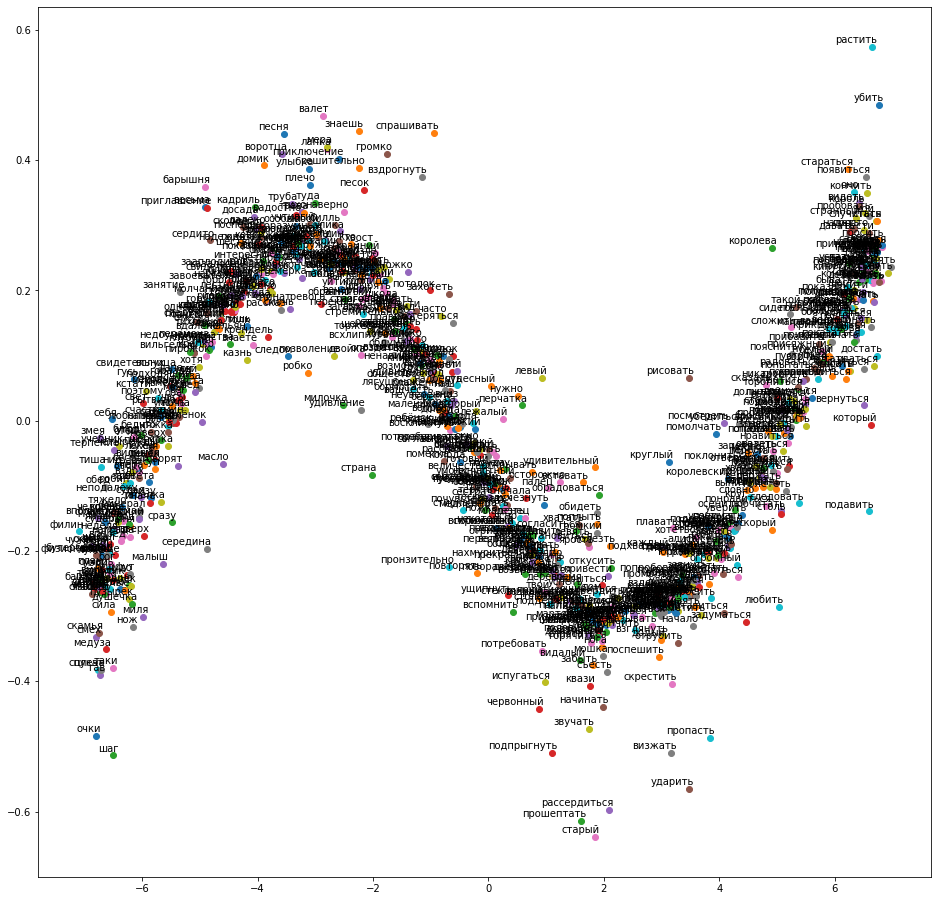

In [9]:
def tsne_plot(model):
    "Creates TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=50, n_components=2, init='pca', n_iter=250, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

# draw our model    
tsne_plot(model)

    Я не придавал этому графику ни какого значения, пока не вспомнил что Льюис Кэрролл был незаурядным математиком:
    А может и правда?
    Вряд ли!
    Хотя...

## Описание персонажа FastText и WordCloud

In [0]:
def most_popular_words(text , tag = 'ADJF', topn=10000):
  """
  Сделать то что описывает персонажа
  """
  all_most_similar = model.wv.most_similar(text, topn=topn)
  ADJF_most_similar = []

  for i in all_most_similar:
    for j in i[:1]:
      p = morph.parse(j)[0]
      if p.tag.POS == tag:
        ADJF_most_similar.append(j)

  cloud = WordCloud(width=700, height=500).generate(str(ADJF_most_similar))
  plt.figure(figsize=(15, 10))
  plt.imshow(cloud)
  plt.axis('off')

  # as a circle
  # x, y = np.ogrid[:300, :300]
  # mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
  # mask = 255 * mask.astype(int)
  # wc = WordCloud(background_color="White", repeat=True, mask=mask)
  # wc.generate(str(ADJF_most_similar))
  # plt.axis("off")
  # plt.imshow(wc, interpolation="bilinear")
  # plt.show()

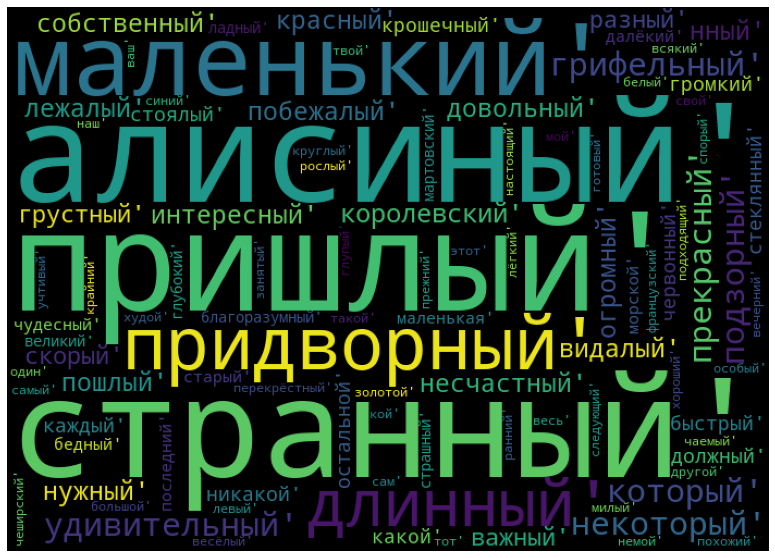

In [11]:
# all that our model has identified is close to Alice
most_popular_words('алиса')

## Частеречная разметка

In [0]:
# load tagged data
full_train = pyconll.load_from_file('./ru_syntagrus-ud-train.conllu') 

In [0]:
# form our X (features) and y (targets)
X = []
y = []
for sent in full_train[:1000]:
    for token in sent:
          X.append(str(token.form))
          if str(token.upos).lower() == 'none':
            y.append(str('PUNCT'))
          else:
            y.append(str(token.upos))

In [0]:
# create SKLEARN class instances
DecisionTreeClf = tree.DecisionTreeClassifier()
LogisticRegressionClf = LogisticRegression()
KNeighborsClf = KNeighborsClassifier()
GaussianNBClf = GaussianNB()
RandomForestClf = RandomForestClassifier(n_jobs=-1)
# GradientBoostingClf = GradientBoostingClassifier()
ngram_vectorizer = CountVectorizer(analyzer='char',  ngram_range=(1, 3) )
scaler = StandardScaler()
le = LabelEncoder()

In [0]:
# convert words to numbers (based on n-gram characters)
X = ngram_vectorizer.fit_transform(X)

# we will divide our data into a training and test sample
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# standardization of our data
X_train = scaler.fit_transform(X_train.toarray())
X_test = scaler.transform(X_test.toarray())

In [0]:
# below we declare parameters for GridSearchCV

cv = 5

max_features = ['auto', 'sqrt']
criterion = ['gini' , 'entropy']
penalty = ['l1', 'l2' ] # , 'elasticnet', 'none']

min_samples_split = [2, 10]
min_samples_leaf = [1, 4]
learning_rate = [0.25 , 0.05]
var_smoothing = [1e-8, 1e-4]
C = [0.01, 1, 100]

n_neighbors = [1 ,  5]
max_depth = [4 ,  8]

KNeighborsClassifier_params = {'n_neighbors': n_neighbors}
LogisticRegression_params = {'C': C  , 'penalty' : penalty } 
DecisionTree_params = {'criterion': criterion , 'max_depth' : max_depth , 'min_samples_split' : min_samples_split , 'min_samples_leaf': min_samples_leaf}
GaussianNBparams = {'var_smoothing': var_smoothing }
RandomForestparams = {'max_features': max_features ,  'max_depth' : max_depth ,  'min_samples_leaf' : min_samples_leaf, 'min_samples_split':min_samples_split } # 'n_estimators' :  250 
GradientBoostingparam = { 'max_depth' : max_depth , 'learning_rate' : learning_rate} 

Clfs = [KNeighborsClf, LogisticRegressionClf , DecisionTreeClf, GaussianNBClf , RandomForestClf ]# , GradientBoostingClf ]
Params = [KNeighborsClassifier_params, LogisticRegression_params , DecisionTree_params, GaussianNBparams, RandomForestparams ]# , GradientBoostingparam ] 


In [0]:
def grid_search_cv(clf , params , X_train, X_test, y_train, y_test):
  """
  This is the function by which we will train all our classifiers in order to compare their results.
  """
  grid_search_cv_clf = GridSearchCV(clf, params , cv = cv)
  grid_search_cv_clf.fit(X_train, y_train)
  best_clf = grid_search_cv_clf.best_estimator_
  return str(clf).split('(')[0] ,  best_clf.score(X_train,y_train) , best_clf.score(X_test,y_test) , grid_search_cv_clf.best_params_

In [18]:
# We look at the result GridSearchCV
tmp = [grid_search_cv(my_Clf , my_Params , X_train, X_test, y_train, y_test) for my_Clf, my_Params  in zip(Clfs,Params)]
pd.DataFrame(tmp, columns=['clf', 'train score' , 'test score', 'params']).sort_values(['test score'] , ascending=False)

,clf,train score,test score,params
1,LogisticRegression,0.980789,0.902151,"{'C': 0.01, 'penalty': 'l2'}"
0,KNeighborsClassifier,0.981488,0.858190,{'n_neighbors': 1}
3,GaussianNB,0.848876,0.762231,{'var_smoothing': 0.0001}
2,DecisionTreeClassifier,0.576784,0.562515,"{'criterion': 'entropy', 'max_depth': 8, 'min_..."
4,RandomForestClassifier,0.551287,0.532971,"{'max_depth': 8, 'max_features': 'auto', 'min_..."


In [0]:
# Neural network
in_neurons = 4346
out_neurons = 17
n_hidden_neurons = 30
batch_size = 10
lr=1.0e-3

In [0]:
# We will prepare our data for PyTorch

le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

X_train = torch.FloatTensor(np.array(X_train))
X_test = torch.FloatTensor(np.array(X_test))

y_train = torch.LongTensor(np.array(y_train))
y_test = torch.LongTensor(np.array(y_test))

In [0]:
# define the architecture of the neural network
class simplePOSTagger(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(simplePOSTagger, self).__init__()
        
        self.fc1 = torch.nn.Linear(in_neurons, n_hidden_neurons)
        self.activ1 = torch.nn.ReLU()
        # self.norm1 = torch.nn.BatchNorm1d(n_hidden_neurons)
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.ReLU()
        self.drop = torch.nn.Dropout(p=0.5)
        self.fc3 = torch.nn.Linear(n_hidden_neurons, out_neurons)
        self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        # x = self.norm1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.drop(x)
        x = self.fc3(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x

# create a neural network
tagger = simplePOSTagger(200)

In [0]:
# loss function
loss = torch.nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.Adam(tagger.parameters(), lr=lr)

#lists for saving statistics
test_accuracy_history = []
test_loss_history = []

In [61]:
# training our network
for epoch in range(1,11):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = tagger.forward(x_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()

        optimizer.step()
        

    test_preds = tagger.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test))

    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    print('Epoch {} finish with accuracy: {}.'.format(epoch, accuracy))

Epoch 1 finish with accuracy: 0.8733159899711609.
Epoch 2 finish with accuracy: 0.8898605704307556.
Epoch 3 finish with accuracy: 0.9016780853271484.
Epoch 4 finish with accuracy: 0.9035689234733582.
Epoch 5 finish with accuracy: 0.904041588306427.
Epoch 6 finish with accuracy: 0.9016780853271484.
Epoch 7 finish with accuracy: 0.9045143127441406.
Epoch 8 finish with accuracy: 0.89009690284729.
Epoch 9 finish with accuracy: 0.888678789138794.
Epoch 10 finish with accuracy: 0.8924604058265686.


### Посмотри статистику обучения:

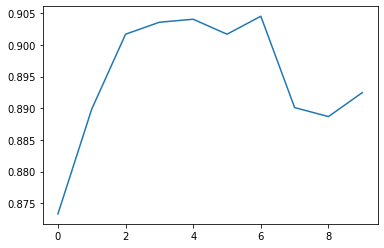

In [62]:
plt.plot(test_accuracy_history);

In [63]:
y_preds = tagger.inference(X_test)
print(classification_report(y_preds.argmax(dim=1).tolist(), y_test ))

              precision    recall  f1-score   support

           0       0.83      0.74      0.78       298
           1       0.99      0.95      0.97       429
           2       0.80      0.87      0.83       234
           3       0.97      0.80      0.88        41
           4       0.98      0.92      0.95       155
           5       0.76      0.65      0.70       105
           6       0.00      0.00      0.00         2
           7       0.88      0.88      0.88       930
           8       0.81      0.83      0.82        41
           9       0.80      0.91      0.85        93
          10       0.83      0.88      0.86       225
          11       0.85      0.90      0.88        94
          12       1.00      1.00      1.00       912
          13       0.81      0.65      0.72        60
          15       0.84      0.88      0.86       612
          16       0.00      0.00      0.00         0

    accuracy                           0.90      4231
   macro avg       0.76   

### Сравним нашу сеть с SPACY

In [0]:
def word_tag(word):
  "Return tag for one word"
  tag = ngram_vectorizer.transform([word])
  tag = scaler.transform(tag.toarray())
  tag = torch.FloatTensor(np.array(tag))
  return  le.classes_[((tagger.forward(tag).argmax(dim=1))[0]).tolist()]

def sentence_tag(sentence):
  "Return tags for one sentense"
  tmp = []
  sentence = sentence.split()
  for i in sentence:
    tmp.append(tuple([i , word_tag(i)]))
  return tmp

In [74]:
text_tag = "Встретились девочка и веселый кролик"
sentence_tag(text_tag)

[('Встретились', 'VERB'),
 ('девочка', 'NOUN'),
 ('и', 'CCONJ'),
 ('веселый', 'ADJ'),
 ('кролик', 'NOUN')]

In [75]:
def spacy_vizualization(text):
  """
  Visualizing the dependency parse(dep) and entity recognizer(ent) with SPACY.
  """
  doc = nlp(text)
  displacy.render(doc, style='dep', jupyter=True, options={'distance': 120})
  # displacy.render(doc, style="ent", jupyter=True)

spacy_vizualization(text_tag)

Посмотрим на ошибки:

In [76]:
text_tag2 = "Приключения Алисы в Стране Чудес"
sentence_tag(text_tag2)

[('Приключения', 'VERB'),
 ('Алисы', 'VERB'),
 ('в', 'ADP'),
 ('Стране', 'NOUN'),
 ('Чудес', 'ADP')]

In [77]:
spacy_vizualization(text_tag2)

Что можно было сделать лучше?

1) При подсчете связей персонажей я не использовал начальные формы слов

2) Модель нейронной сети очень проста, не используются сверточные или рекуррентные сети

3) Параметры для модели FastText можно было подобрать лучше и можно было попробовать использовать предобученную модель